# Time Domain Analysis 

## Intro

S-parameters are measured in the frequency domain, but can be analysised in the frequency and/or time domain. In most cases, however, measurements are not made down to DC (frequency =0), so the time-domain transform is not complete, but useful non-theless. More information about the details of time domain analysis see [1]. 

This notebooks demonstrates how to use time-domain analysis in [scikit-rf](www.scikit-rf.org). A quick example is given first, followed by a more detailed explanation.

References

* [1] Agilent Time Domain Analysis Using a Network Analyzer (Application Note 1287-12) [pdf](http://cp.literature.agilent.com/litweb/pdf/5989-5723EN.pdf)

### Quick Example

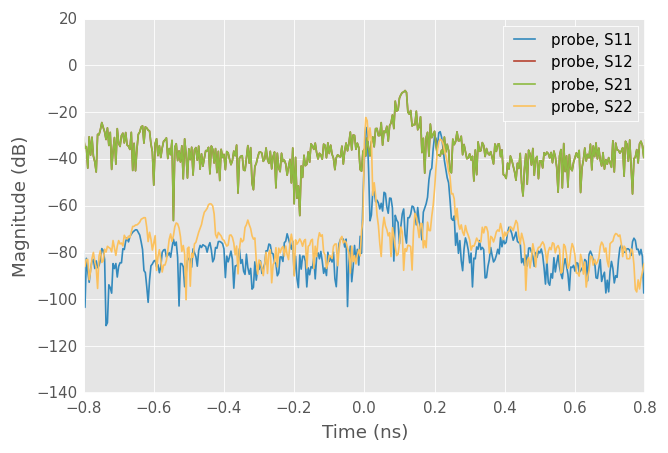

In [3]:
import skrf as rf 
%matplotlib inline
rf.stylely()
from pylab import * 

probe = rf.Network('oneport_tiered_calibration/probe.s2p')
probe.plot_s_db_time()

# Time Domain in Detail

For this example we will use a waveguide-to-CPW probe, that was measured in [this example](./oneport_tiered_calibration/One Port Tiered Calibration.ipynb)  as a sample DUT. 

In [7]:
import skrf as rf

probe = rf.Network('oneport_tiered_calibration/probe.s2p')
probe

2-Port Network: 'probe',  500-750 GHz, 401 pts, z0=[ 50.+0.j  50.+0.j]

## Time Domain

Plotting the Network in both frequency and time-domain

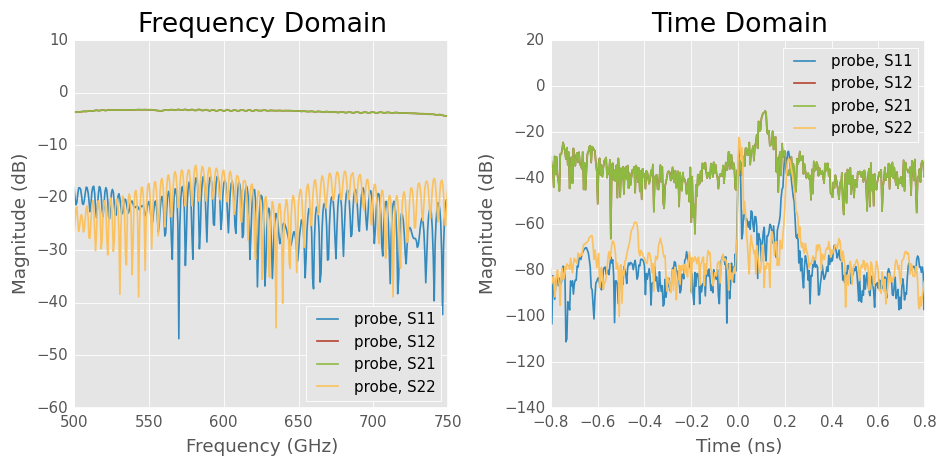

In [6]:
# plot frequency and time-domain s-parameters
figure(figsize=(8,4))
subplot(121)
probe.plot_s_db()
title('Frequency Domain')
subplot(122)
probe.plot_s_db_time()
title('Time Domain')
tight_layout()
savefig('/home/alex/Desktop/example.svg')

Look at just the reflection coefficient from the waveguide port, you can see there is a large ripple present.

In [ ]:
probe.plot_s_db(0,0)
title('Reflection Coefficient From \nWaveguide Port')

This ripple is evidence of one or more (probably 3) impulse-like reflections. Plotting this in the time-domain we can see *when* these reflections occur.

In [ ]:
probe.plot_s_db_time(0,0)
title('Reflection Coefficient From \nWaveguide Port, Time Domain')
ylim(-100,0)

From this plot we can see two dominant reflections; 
* one at $t=0$ns (the test-port) 
* and another  at $t=2$ns (who knows?!).


## Determining Distance

To make time-domain useful as a diagnostic tool, one would like to convert the x-axis to distance. This requires knowledge of the propagation velocity in the device.  **skrf** provides some transmission-line models in the module [skrf.media](http://scikit-rf.readthedocs.org/en/latest/reference/media/index.html), which we can be used for this.

**However...**

For dispersive media, such as rectangular waveguide, the phase velocity is a function of frequency, and transforming time to distance is not straightforward. As an approximation, you can normalize the x-axis to the speed of light.

Alternativly, you can simulate the  a known device and compare the two time domain responses. This allows you to attribute quantatative meaning to the axes. For example, you could create an ideal delayed load as shown below.


In [ ]:
from skrf.media import RectangularWaveguide
cm = 1e-2

# create a rectangular waveguide media to gererate a theoretical network
wr1p5 = RectangularWaveguide(frequency=probe.frequency, 
                             a=15*rf.mil,z0=1) 

# create an ideal delayed load, parameters are adjusted until the
# theoretical response agrees with the measurement
theory = wr1p5.delay_load(Gamma0=rf.db_2_mag(-20),
                          d=2.4*cm)


probe.plot_s_db_time(0,0, label = 'Measurement')
theory.plot_s_db_time(label='-20dB @ 2.4cm from test-port')
ylim(-100,0)

This plot demonstrates a few important points:

* the theortical delayed load is not a perfect impulse in time. This is due to the dispersion in waveguide. 
* the peak of the magnitude in time domain is not identical to that specified, this is 

## What the hell is Windowing?

The `'plot_s_db_time()'` function does a few things. 
1. First it windows the s-parameters. 
* Then converts to time domain  
* takes magnitude component, convert to dB
* calculates time-axis s
* plots

A word about step 1: **windowing**. As mentioned above the s-parameter data is generally band-limited, meaning not measured down to DC. Thus, when a FFT is calculated, it is implicitly calculating the results of the entire spectrum multiplied by a rect window. This rect introduces artifacts in the time-domain results. To minimize these effects, the frequency response is *windowed*. 

In skrf this can be done explicitly using the `'windowed()'` function.  By default this function uses the hamming window, but can be adjusted through arguments. The result of windowing is show below. 


In [ ]:
probe_w = probe.windowed()
probe.plot_s_db(0,0, label = 'Oringal')
probe_w.plot_s_db(0,0, label = 'Windowed')


Ploting the two results in time domain, 

In [ ]:
probe.plot_s_time_db(0,0, label = 'Original')
probe_w.plot_s_time_db(0,0, label = 'Windowed')

### Formating junk

In [ ]:
from IPython.core.display import HTML


def css_styling():
    styles = open("./styles/plotly.css", "r").read()
    return HTML(styles)
css_styling()